In [1]:
# !ls adversarial-robustness-toolbox/
import os
os.chdir('/home/surthi/adversarial-robustness-toolbox/')

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import tensorflow as tf
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
from keras.regularizers import l2
import numpy as np
from art.attacks import DeepFool
from art.classifiers import KerasClassifier
from art.utils import load_dataset

Using TensorFlow backend.


In [3]:
def evaluate(clf, x_train, y_train, x_test, y_test):
    # train acc
    train_preds = np.argmax(clf.predict(x_train), axis=1)
    train_acc = np.sum(train_preds == np.argmax(y_train, axis=1)) / y_train.shape[0]
    # test acc
    test_preds = np.argmax(clf.predict(x_test), axis=1)
    test_acc = np.sum(test_preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    print("\nTraining and Test accuracies: %.2f %.2f%%" % (train_acc*100, test_acc*100))
    return train_acc, test_acc

def plot_curves(model, title='model accuracy and loss'):
    import matplotlib.pyplot as plt
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['loss'])
    plt.title(title)
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'Loss'], loc='upper left')
    return plt

def save_clf(c, folder, clf_filename, model_filename):
    cwd = os.getcwd()
    os.chdir(folder)
    import pickle
    with open(clf_filename, "wb") as f:
        pickle.dump(c.__getstate__, f)
    c._model.save(model_filename)
    os.chdir(cwd)

DUMP_FOLDER = '/home/surthi/models/'
def pickle_dump(data, filename, folder=DUMP_FOLDER):
    cwd = os.getcwd()
    os.chdir(folder)
    print(os.getcwd())
    import pickle
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    os.chdir(cwd)

def pickle_load(filename):
    import pickle
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_clf(folder, clf_filename, model_filename):
    cwd = os.getcwd()
    os.chdir(folder)
    import pickle
    with open(clf_filename, "rb") as f:
        clf_state = pickle.load(f)
    model = tf.keras.models.load_model(model_filename)
    os.chdir(cwd)
    clf = KerasClassifier(model=model)
    clf.__setstate__(clf_state())
    return clf, model

In [4]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

# MNIST CNN MODEL

In [11]:
def get_vanilla_model(x_train, y_train, batch_norm=False):
    m = Sequential()

    m.add(Conv2D(64, (3, 3), padding='valid', input_shape=(28, 28, 1)))
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())
    m.add(Conv2D(64, (3, 3)))
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())
    m.add(MaxPooling2D(pool_size=(2, 2)))
    m.add(Dropout(0.5))
    m.add(Flatten())
    m.add(Dense(128))         
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())
    m.add(Dropout(0.5))
    m.add(Dense(10))
    m.add(Activation('softmax'))
    m.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    c = KerasClassifier(model=m)
    c.fit(x_train, y_train, nb_epochs=50, batch_size=128)
    return c


# MNIST CNN MODEL WITH BATCHNORM

In [7]:
vanilla_clf_with_bn = get_vanilla_model(x_train, y_train, batch_norm=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
469/469 [==============================] - 17s 36ms/step - loss: 0.1788 - acc: 0.9471
Epoch 2/50
469/469 [==============================] - 13s 28ms/step - loss: 0.0651 - acc: 0.9798
Epoch 3/50
469/469 [==============================] - 14s 29ms/step - loss: 0.0531 - acc: 0.9839
Epoch 4/50
469/469 [==============================] - 13s 29ms/step - loss: 0.0447 - acc: 0.9865
Epoch 5/50
469/469 [==============================] - 13s 29ms/step - loss: 0.0410 - acc: 0.9870
Epoch 6/50
469/469 [==============================] - 14s 29ms/step - loss: 0.0357 - acc:

In [9]:
save_clf(vanilla_clf_with_bn, '/home/surthi/models/mnist/', 'vanilla_clf_with_bn.h5', 'vanilla_clf_with_bn_model.h5')

In [10]:
evaluate(vanilla_clf_with_bn, x_train, y_train, x_test, y_test)


Training and Test accuracies: 100.00 99.32%


(0.99995, 0.9932)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

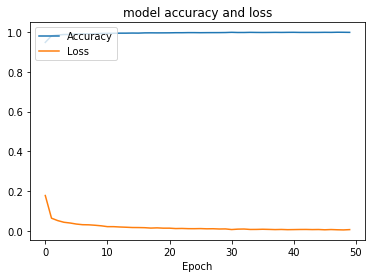

In [13]:
plot_curves(vanilla_clf_with_bn._model)

In [12]:
print(vanilla_clf_with_bn._model.history.history['acc'])
print(vanilla_clf_with_bn._model.history.history['loss'])

[0.9470615671641791, 0.9798274253731343, 0.9838752665245203, 0.9864738805970149, 0.9869569562899787, 0.9888392857142857, 0.9900053304904051, 0.9896388592750534, 0.9905883528784648, 0.9918876599147122, 0.9924373667377399, 0.9927372068230277, 0.9932702558635395, 0.9933535447761194, 0.9938033049040512, 0.9935367803837953, 0.9946528518123667, 0.9948694029850746, 0.9946861673773987, 0.9947861140724946, 0.9949693496801706, 0.9955523720682303, 0.9955357142857143, 0.9960021321961621, 0.99596881663113, 0.9956190031982942, 0.9959021855010661, 0.995985474413646, 0.996068763326226, 0.9964518923240938, 0.9974680170575693, 0.9966184701492538, 0.9966517857142857, 0.9972847814498934, 0.9969016524520256, 0.9966851012793176, 0.9969016524520256, 0.9972847814498934, 0.9969516257995735, 0.9973514125799574, 0.9975179904051172, 0.9969849413646056, 0.9970349147121536, 0.9970182569296375, 0.9970682302771855, 0.9974846748400853, 0.9972348081023454, 0.9978844616204691, 0.9977012260127932, 0.9973014392324094]
[0.

# MNIST CNN MODEL WITHOUT BATCHNORM

In [14]:
vanilla_clf = get_vanilla_model(x_train, y_train)
save_clf(vanilla_clf, '/home/surthi/models/mnist/', 'vanilla_clf.h5', 'vanilla_clf_model.h5')

Epoch 1/50
469/469 [==============================] - 10s 22ms/step - loss: 0.2383 - acc: 0.9272
Epoch 2/50
469/469 [==============================] - 10s 20ms/step - loss: 0.0891 - acc: 0.9730
Epoch 3/50
469/469 [==============================] - 9s 20ms/step - loss: 0.0701 - acc: 0.9786
Epoch 4/50
469/469 [==============================] - 10s 20ms/step - loss: 0.0563 - acc: 0.9828
Epoch 5/50
469/469 [==============================] - 9s 20ms/step - loss: 0.0531 - acc: 0.9835
Epoch 6/50
469/469 [==============================] - 10s 20ms/step - loss: 0.0448 - acc: 0.9857
Epoch 7/50
469/469 [==============================] - 10s 21ms/step - loss: 0.0440 - acc: 0.9863
Epoch 8/50
469/469 [==============================] - 10s 20ms/step - loss: 0.0400 - acc: 0.9869
Epoch 9/50
469/469 [==============================] - 10s 20ms/step - loss: 0.0363 - acc: 0.9878
Epoch 10/50
469/469 [==============================] - 10s 20ms/step - loss: 0.0355 - acc: 0.9888
Epoch 11/50
469/469 [==========

# Adversarial Generation

In [7]:
def deepfool(clf, x_train, x_test):
    from art.attacks import DeepFool
    deep_adv_crafter = DeepFool(clf)
    x_train_deepfool_adv = deep_adv_crafter.generate(x_train)
    x_test_deepfool_adv = deep_adv_crafter.generate(x_test)
    return x_train_deepfool_adv, x_test_deepfool_adv

def carlinil2(clf, x_train, x_test):
    from art.attacks import CarliniL2Method
    cl2_adv_crafter = CarliniL2Method(classifier=clf, targeted=False, max_iter=5)
    x_train_cl2_adv = cl2_adv_crafter.generate(x_train)
    x_test_cl2_adv = cl2_adv_crafter.generate(x_test)
    return x_train_cl2_adv, x_test_cl2_adv

In [10]:
x_train_cl2_adv, x_test_cl2_adv = carlinil2(vanilla_clf, x_train[:5000], x_test[:1000])
evaluate(vanilla_clf, x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])


Training and Test accuracies: 17.06 14.40%


(0.1706, 0.144)

In [11]:
pickle_dump((x_train_cl2_adv, x_test_cl2_adv), 'mnist-cl2-data.pkl')

In [12]:
x_train_deepfool_adv, x_test_deepfool_adv = deepfool(vanilla_clf, x_train[:5000], x_test[:1000])
evaluate(vanilla_clf, x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])


Training and Test accuracies: 11.34 11.20%


(0.1134, 0.112)

In [13]:
pickle_dump((x_train_deepfool_adv, x_test_deepfool_adv), 'mnist-deepfool-data.pkl')

In [7]:
def fgsm(clf, x_train, x_test, epsilon=0.1):
    from art.attacks.fast_gradient import FastGradientMethod
    epsilon = .1  # Maximum perturbation
#     fgsm_adv_crafter = FastGradientMethod(clf, eps=epsilon)
#     fgsm_adv_crafter = FastGradientMethod(clf, eps=0.4, batch_size=2)
    fgsm_adv_crafter = FastGradientMethod(clf, eps=0.4, eps_step=0.01, batch_size=2)
    x_test_fgsm_adv = fgsm_adv_crafter.generate(x=x_test)
    x_train_fgsm_adv = fgsm_adv_crafter.generate(x=x_train)
    return x_train_fgsm_adv, x_test_fgsm_adv

def ifgsm(clf, x_train, x_test, epsilon=0.1, max_iter=10):
    from art.attacks.iterative_method import BasicIterativeMethod
    ifgsm_adv_crafter = BasicIterativeMethod(clf, eps=epsilon, eps_step=0.1, max_iter=max_iter)
    x_test_ifgsm_adv = ifgsm_adv_crafter.generate(x=x_test)
    x_train_ifgsm_adv = ifgsm_adv_crafter.generate(x=x_train)
    return x_train_ifgsm_adv, x_test_ifgsm_adv

x_train_fgsm_adv, x_test_fgsm_adv = fgsm(vanilla_clf, x_train, x_test, epsilon=1.0)
evaluate(vanilla_clf, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
pickle_dump((x_train_fgsm_adv, x_test_fgsm_adv), 'mnist-fgsm-data.pkl')


Training and Test accuracies: 28.83 30.52%
/home/surthi/models


In [ ]:
from art.attacks.iterative_method import BasicIterativeMethod
ifgsm_adv_crafter = BasicIterativeMethod(vanilla_clf, eps=0.1, eps_step=0.1, max_iter=20)
x_test_ifgsm_adv = ifgsm_adv_crafter.generate(x=x_test)
x_train_ifgsm_adv = ifgsm_adv_crafter.generate(x=x_train)
evaluate(vanilla_clf, x_train_ifgsm_adv, y_train, x_test_ifgsm_adv, y_test)

In [22]:
x_train_ifgsm_adv, x_test_ifgsm_adv = ifgsm(vanilla_clf, x_train, x_test)
evaluate(vanilla_clf, x_train_ifgsm_adv, y_train, x_test_ifgsm_adv, y_test)
pickle_dump((x_train_ifgsm_adv, x_test_ifgsm_adv), 'mnist-ifgsm-data.pkl')


Training and Test accuracies: 0.02 0.51%


In [27]:
pickle_dump((x_train_ifgsm_adv, x_test_ifgsm_adv), 'mnist-ifgsm-data.pkl')

/home/surthi/models


In [5]:
x_train_cl2_adv, x_test_cl2_adv = pickle_load('/home/surthi/models/mnist-cl2-data.pkl')
x_train_deepfool_adv, x_test_deepfool_adv = pickle_load('/home/surthi/models/mnist-deepfool-data.pkl')
x_train_fgsm_adv, x_test_fgsm_adv = pickle_load('/home/surthi/models/mnist-fgsm-data.pkl')
x_train_ifgsm_adv1, x_test_ifgsm_adv1 = pickle_load('/home/surthi/models/mnist-ifgsm-data.pkl')

In [6]:
pickle_dump([x_train[5], x_train_ifgsm_adv1[5],x_train_fgsm_adv[5], x_train_deepfool_adv[5], x_train_cl2_adv[5]], "mnist-5images.pkl")

/home/surthi/models


# Evaluating Acc of Models against adversarials

In [36]:
train_acc, test_acc = evaluate(vanilla_clf, x_train, y_train, x_test, y_test)
fgsm_train_acc, fgsm_test_acc = evaluate(vanilla_clf, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc, ifgsm_test_acc = evaluate(vanilla_clf, x_train_ifgsm_adv1, y_train, x_test_ifgsm_adv1, y_test)
df_train_acc, df_test_acc = evaluate(vanilla_clf, x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
cl2_train_acc, cl2_test_acc = evaluate(vanilla_clf, x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])


Training and Test accuracies: 99.98 99.40%

Training and Test accuracies: 28.83 30.52%

Training and Test accuracies: 0.02 0.51%

Training and Test accuracies: 11.34 11.20%

Training and Test accuracies: 17.06 14.40%


In [38]:
train_acc, test_acc = evaluate(vanilla_clf_with_bn, x_train, y_train, x_test, y_test)
fgsm_train_acc, fgsm_test_acc = evaluate(vanilla_clf_with_bn, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc, ifgsm_test_acc = evaluate(vanilla_clf_with_bn, x_train_ifgsm_adv1, y_train, x_test_ifgsm_adv1, y_test)
df_train_acc, df_test_acc = evaluate(vanilla_clf_with_bn, x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
cl2_train_acc, cl2_test_acc = evaluate(vanilla_clf_with_bn, x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])


Training and Test accuracies: 100.00 99.32%

Training and Test accuracies: 24.70 24.66%

Training and Test accuracies: 2.05 2.43%

Training and Test accuracies: 88.98 91.00%

Training and Test accuracies: 70.30 68.70%


# Adversarial Training

In [39]:
def adv_training_1(clf, x_train, y_train, x_train_adv, x_test_adv, x_test, y_test, epochs=5, batch_size=128):
    print("Before training:")
    evaluate(clf, x_train, y_train, x_test, y_test)    
    evaluate(clf, x_train_adv, y_train, x_test_adv, y_test)
    
    for i in range(epochs):
        clf.fit(x_train_adv, y_train, nb_epochs=1, batch_size=128)
        clf.fit(x_train, y_train, nb_epochs=1, batch_size=128)
    
    print("After training:")
    evaluate(clf, x_train, y_train, x_test, y_test)    
    evaluate(clf, x_train_adv, y_train, x_test_adv, y_test)
    return clf

In [40]:
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)

Before training:

Training and Test accuracies: 99.98 99.40%

Training and Test accuracies: 0.02 0.51%
Epoch 1/1
469/469 [==============================] - 11s 23ms/step - loss: 16.1141 - acc: 2.4987e-04
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0136 - acc: 0.9957
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 16.1159 - acc: 1.3326e-04
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0142 - acc: 0.9957
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 16.1146 - acc: 2.1655e-04
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0159 - acc: 0.9950
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 16.1157 - acc: 1.4992e-04
Epoch 1/1
469/469 [==============================] - 10s 22ms/step - loss: 0.0142 - acc: 0.9953
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 16.1130 - acc: 3.1650e-04
Epoch 1/

In [41]:
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)


Before training:

Training and Test accuracies: 99.98 99.34%

Training and Test accuracies: 0.02 0.51%
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 16.1154 - acc: 1.6658e-04
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0150 - acc: 0.9951
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 16.1141 - acc: 2.4987e-04
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0137 - acc: 0.9958
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 16.1146 - acc: 2.1655e-04
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0138 - acc: 0.9955
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 16.1141 - acc: 2.4987e-04
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0140 - acc: 0.9953
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 16.1130 - acc: 3.1650e-04
Epoch 1/

In [42]:
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)

Before training:

Training and Test accuracies: 99.98 99.31%

Training and Test accuracies: 11.24 11.35%
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.3162 - acc: 0.1118
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0127 - acc: 0.9958
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.3141 - acc: 0.1119
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0132 - acc: 0.9957
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.3592 - acc: 0.1091
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0157 - acc: 0.9954
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.2803 - acc: 0.1140
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0128 - acc: 0.9963
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.2988 - acc: 0.1129
Epoch 1/1
469/469 [=======

In [44]:
save_clf(vanilla_clf, '/home/surthi/models/mnist/', 'vanilla_clf_adv.h5', 'vanilla_clf_model_adv.h5')

In [45]:
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)

Before training:

Training and Test accuracies: 99.99 99.31%

Training and Test accuracies: 11.24 11.35%
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.3275 - acc: 0.1111
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0101 - acc: 0.9966
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.2803 - acc: 0.1140
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0112 - acc: 0.9966
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.3246 - acc: 0.1113
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0118 - acc: 0.9967
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.3154 - acc: 0.1118
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0110 - acc: 0.9964
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.3112 - acc: 0.1121
Epoch 1/1
469/469 [=======

In [46]:
save_clf(vanilla_clf, '/home/surthi/models/mnist/', 'vanilla_clf_adv.h5', 'vanilla_clf_model_adv.h5')

In [47]:
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1 = adv_training_1(vanilla_clf, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)

Before training:

Training and Test accuracies: 100.00 99.35%

Training and Test accuracies: 11.24 11.35%
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.3077 - acc: 0.1123
Epoch 1/1
469/469 [==============================] - 10s 22ms/step - loss: 0.0100 - acc: 0.9972
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.2953 - acc: 0.1131
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0105 - acc: 0.9968
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.2795 - acc: 0.1141
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0089 - acc: 0.9970
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.3136 - acc: 0.1120
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 0.0104 - acc: 0.9968
Epoch 1/1
469/469 [==============================] - 10s 21ms/step - loss: 14.3165 - acc: 0.1118
Epoch 1/1
469/469 [======

In [48]:
save_clf(vanilla_clf, '/home/surthi/models/mnist/', 'vanilla_clf_adv.h5', 'vanilla_clf_model_adv.h5')

# BN Adversarial Training

In [49]:
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)

Before training:

Training and Test accuracies: 100.00 99.32%

Training and Test accuracies: 2.05 2.43%
Epoch 1/1
469/469 [==============================] - 15s 32ms/step - loss: 0.5868 - acc: 0.8998
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0727 - acc: 0.9781
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0863 - acc: 0.9738
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0316 - acc: 0.9895
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0552 - acc: 0.9830
Epoch 1/1
469/469 [==============================] - 14s 30ms/step - loss: 0.0254 - acc: 0.9919
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0434 - acc: 0.9865
Epoch 1/1
469/469 [==============================] - 14s 30ms/step - loss: 0.0248 - acc: 0.9921
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0366 - acc: 0.9889
Epoch 1/1
469/469 [=============

In [50]:
vanilla_clf_with_bn._model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
__________

In [51]:
vanilla_clf._model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
activation_6 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
__________

In [53]:
save_clf(vanilla_clf_with_bn, '/home/surthi/models/mnist/', 'vanilla_clf_bn_adv.h5', 'vanilla_clf_bn_model_adv.h5')

In [54]:
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)

Before training:

Training and Test accuracies: 99.98 99.28%

Training and Test accuracies: 72.16 72.29%
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0121 - acc: 0.9966
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0137 - acc: 0.9957
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0080 - acc: 0.9974
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0096 - acc: 0.9966
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0065 - acc: 0.9982
Epoch 1/1
469/469 [==============================] - 14s 30ms/step - loss: 0.0103 - acc: 0.9965
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0055 - acc: 0.9984
Epoch 1/1
469/469 [==============================] - 14s 30ms/step - loss: 0.0098 - acc: 0.9966
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0074 - acc: 0.9980
Epoch 1/1
469/469 [============

In [56]:
save_clf(vanilla_clf_with_bn, '/home/surthi/models/mnist/', 'vanilla_clf_bn_adv.h5', 'vanilla_clf_bn_model_adv.h5')

In [57]:
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)
vanilla_clf_adv_trained_1bn = adv_training_1(vanilla_clf_with_bn, x_train, y_train, x_train_ifgsm_adv, x_test_ifgsm_adv, x_test, y_test, epochs=5)

Before training:

Training and Test accuracies: 99.99 99.33%

Training and Test accuracies: 74.12 74.16%
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0050 - acc: 0.9986
Epoch 1/1
469/469 [==============================] - 14s 30ms/step - loss: 0.0073 - acc: 0.9977
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0048 - acc: 0.9987
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0092 - acc: 0.9972
Epoch 1/1
469/469 [==============================] - 14s 30ms/step - loss: 0.0056 - acc: 0.9984
Epoch 1/1
469/469 [==============================] - 14s 30ms/step - loss: 0.0079 - acc: 0.9974
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0061 - acc: 0.9983
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0073 - acc: 0.9973
Epoch 1/1
469/469 [==============================] - 14s 29ms/step - loss: 0.0062 - acc: 0.9986
Epoch 1/1
469/469 [============

In [58]:
save_clf(vanilla_clf_with_bn, '/home/surthi/models/mnist/', 'vanilla_clf_bn_adv.h5', 'vanilla_clf_bn_model_adv.h5')

In [59]:
loaded_vanilla_clf_with_bn_adv = load_clf('/home/surthi/models/mnist/', 'vanilla_clf_bn_adv.h5', 'vanilla_clf_bn_model_adv.h5')
loaded_vanilla_clf_adv = load_clf('/home/surthi/models/mnist/', 'vanilla_clf_adv.h5', 'vanilla_clf_model_adv.h5')
loaded_vanilla_clf = load_clf('/home/surthi/models/mnist/', 'vanilla_clf.h5', 'vanilla_clf_model.h5')
loaded_vanilla_clf_with_bn = load_clf('/home/surthi/models/mnist/', 'vanilla_clf_with_bn.h5', 'vanilla_clf_with_bn_model.h5')

# Adversarial Detector = Ensemble of MNIST-CNN-WITHOUT-BatchNorm and MNIST-BIM-ADV-TRAINED MODEL
## If both the models agree, then its clean image else its an adversarial. It detected other black-box attacks well

In [65]:
preds1 = np.argmax(loaded_vanilla_clf[0].predict(x_test), axis=1)
preds2 = np.argmax(loaded_vanilla_clf_with_bn_adv[0].predict(x_test), axis=1)
clean_adv_detection = preds1 == preds2
np.ones(clean_adv_detection.shape, dtype=int)
from sklearn.metrics import classification_report
print(classification_report(np.ones(clean_adv_detection.shape, dtype=int), clean_adv_detection))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      1.00     10000

    accuracy                           0.99     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      0.99      1.00     10000



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [71]:
preds1 = np.argmax(loaded_vanilla_clf[0].predict(x_test_ifgsm_adv1), axis=1)
preds2 = np.argmax(loaded_vanilla_clf_with_bn_adv[0].predict(x_test_ifgsm_adv1), axis=1)
clean_adv_detection = preds1 != preds2
np.ones(clean_adv_detection.shape, dtype=int)
from sklearn.metrics import classification_report
print(classification_report(np.ones(clean_adv_detection.shape, dtype=int), clean_adv_detection))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000



In [72]:
preds1 = np.argmax(loaded_vanilla_clf[0].predict(x_test_fgsm_adv), axis=1)
preds2 = np.argmax(loaded_vanilla_clf_with_bn_adv[0].predict(x_test_fgsm_adv), axis=1)
clean_adv_detection = preds1 != preds2
np.ones(clean_adv_detection.shape, dtype=int)
from sklearn.metrics import classification_report
print(classification_report(np.ones(clean_adv_detection.shape, dtype=int), clean_adv_detection))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.86      0.93     10000

    accuracy                           0.86     10000
   macro avg       0.50      0.43      0.46     10000
weighted avg       1.00      0.86      0.93     10000



In [74]:
preds1 = np.argmax(loaded_vanilla_clf[0].predict(x_test_cl2_adv), axis=1)
preds2 = np.argmax(loaded_vanilla_clf_with_bn_adv[0].predict(x_test_cl2_adv), axis=1)
clean_adv_detection = preds1 != preds2
np.ones(clean_adv_detection.shape, dtype=int)
from sklearn.metrics import classification_report
print(classification_report(np.ones(clean_adv_detection.shape, dtype=int), clean_adv_detection))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.77      0.87      1000

    accuracy                           0.77      1000
   macro avg       0.50      0.38      0.43      1000
weighted avg       1.00      0.77      0.87      1000



In [75]:
preds1 = np.argmax(loaded_vanilla_clf[0].predict(x_test_deepfool_adv), axis=1)
preds2 = np.argmax(loaded_vanilla_clf_with_bn_adv[0].predict(x_test_deepfool_adv), axis=1)
clean_adv_detection = preds1 != preds2
np.ones(clean_adv_detection.shape, dtype=int)
from sklearn.metrics import classification_report
print(classification_report(np.ones(clean_adv_detection.shape, dtype=int), clean_adv_detection))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.88      0.93      1000

    accuracy                           0.88      1000
   macro avg       0.50      0.44      0.47      1000
weighted avg       1.00      0.88      0.93      1000



# Average Perturbations

In [79]:
import numpy.linalg as la
N = 3000
bim_perturbation = np.mean(la.norm((x_train[:N]-x_test_ifgsm_adv1[:N]).reshape(N, -1), 2, axis=1))
fgsm_perturbation = np.mean(la.norm((x_train[:N]-x_train_fgsm_adv[:N]).reshape(N, -1), 2, axis=1))
cl2_perturbation = np.mean(la.norm((x_train[:N]-x_train_cl2_adv[:N]).reshape(N, -1), 2, axis=1))
df_perturbation = np.mean(la.norm((x_train[:N]-x_train_deepfool_adv[:N]).reshape(N, -1), 2, axis=1))

In [80]:
print(bim_perturbation, fgsm_perturbation, cl2_perturbation, df_perturbation)

19.01417679975898 8.968844231824544 2.6234788295148164 1.452307249586318


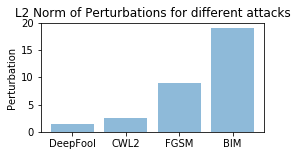

In [83]:
avg_perturbations = (1.452307249586318, 2.6234788295148164, 8.968844231824544, 19.01417679975898)

import matplotlib.pyplot as plt
plt.figure(figsize=(4,2))
y_pos = np.arange(len(avg_perturbations))
plt.bar(y_pos, avg_perturbations, align='center', alpha=0.5)
plt.xticks(y_pos, ['DeepFool', 'CWL2', 'FGSM', 'BIM'])
plt.title('L2 Norm of Perturbations for different attacks')
# plt.xlabel('Attack Types')
plt.ylabel('Perturbation')
plt.show()

# Accuracy Plot

In [96]:
train_acc, test_acc = evaluate(loaded_vanilla_clf[0], x_train, y_train, x_test, y_test)
fgsm_train_acc, fgsm_test_acc = evaluate(loaded_vanilla_clf[0], x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc, ifgsm_test_acc = evaluate(loaded_vanilla_clf[0], x_train_ifgsm_adv1, y_train, x_test_ifgsm_adv1, y_test)
df_train_acc, df_test_acc = evaluate(loaded_vanilla_clf[0], x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
cl2_train_acc, cl2_test_acc = evaluate(loaded_vanilla_clf[0], x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])

train_acc_bn, test_acc_bn = evaluate(loaded_vanilla_clf_with_bn[0], x_train, y_train, x_test, y_test)
fgsm_train_acc_bn, fgsm_test_acc_bn = evaluate(loaded_vanilla_clf_with_bn[0], x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc_bn, ifgsm_test_acc_bn = evaluate(loaded_vanilla_clf_with_bn[0], x_train_ifgsm_adv1, y_train, x_test_ifgsm_adv1, y_test)
df_train_acc_bn, df_test_acc_bn = evaluate(loaded_vanilla_clf_with_bn[0], x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
cl2_train_acc_bn, cl2_test_acc_bn = evaluate(loaded_vanilla_clf_with_bn[0], x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])


Training and Test accuracies: 99.98 99.40%

Training and Test accuracies: 28.83 30.52%

Training and Test accuracies: 0.02 0.51%

Training and Test accuracies: 11.34 11.20%

Training and Test accuracies: 17.06 14.40%

Training and Test accuracies: 100.00 99.32%

Training and Test accuracies: 24.70 24.66%

Training and Test accuracies: 2.05 2.43%

Training and Test accuracies: 88.98 91.00%

Training and Test accuracies: 70.30 68.70%


In [95]:
train_acc_bn_adv, test_acc_bn_adv = evaluate(loaded_vanilla_clf_with_bn_adv[0], x_train, y_train, x_test, y_test)
fgsm_train_acc_bn_adv, fgsm_test_acc_bn_adv = evaluate(loaded_vanilla_clf_with_bn_adv[0], x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc_bn_adv, ifgsm_test_acc_bn_adv = evaluate(loaded_vanilla_clf_with_bn_adv[0], x_train_ifgsm_adv1, y_train, x_test_ifgsm_adv1, y_test)
df_train_acc_bn_adv, df_test_acc_bn_adv = evaluate(loaded_vanilla_clf_with_bn_adv[0], x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
cl2_train_acc_bn_adv, cl2_test_acc_bn_adv = evaluate(loaded_vanilla_clf_with_bn_adv[0], x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])


Training and Test accuracies: 99.99 99.30%

Training and Test accuracies: 34.24 34.33%

Training and Test accuracies: 76.78 76.39%

Training and Test accuracies: 97.10 97.80%

Training and Test accuracies: 89.60 89.40%


In [97]:
train_acc_adv, test_acc_adv = evaluate(loaded_vanilla_clf_adv[0], x_train, y_train, x_test, y_test)
fgsm_train_acc_adv, fgsm_test_acc_adv = evaluate(loaded_vanilla_clf_adv[0], x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc_adv, ifgsm_test_acc_adv = evaluate(loaded_vanilla_clf_adv[0], x_train_ifgsm_adv1, y_train, x_test_ifgsm_adv1, y_test)
df_train_acc_adv, df_test_acc_adv = evaluate(loaded_vanilla_clf_adv[0], x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
cl2_train_acc_adv, cl2_test_acc_adv = evaluate(loaded_vanilla_clf_adv[0], x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])


Training and Test accuracies: 100.00 99.35%

Training and Test accuracies: 11.24 11.35%

Training and Test accuracies: 11.24 11.35%

Training and Test accuracies: 72.44 75.00%

Training and Test accuracies: 69.62 68.40%


In [98]:
acc1 = (train_acc, df_train_acc, cl2_train_acc, fgsm_train_acc, ifgsm_train_acc)
test_acc1 = (test_acc, df_test_acc, cl2_test_acc, fgsm_test_acc, ifgsm_test_acc)
acc_bn1 = (train_acc_bn, df_train_acc_bn, cl2_train_acc_bn, fgsm_train_acc_bn, ifgsm_train_acc_bn)
test_acc_bn1 = (test_acc_bn, df_test_acc_bn, cl2_test_acc_bn, fgsm_test_acc_bn, ifgsm_test_acc_bn)
acc1_adv = (train_acc_adv, df_train_acc_adv, cl2_train_acc_adv, fgsm_train_acc_adv, ifgsm_train_acc_adv)
test_acc1_adv = (test_acc_adv, df_test_acc_adv, cl2_test_acc_adv, fgsm_test_acc_adv, ifgsm_test_acc_adv)
acc_bn1_adv = (train_acc_bn_adv, df_train_acc_bn_adv, cl2_train_acc_bn_adv, fgsm_train_acc_bn_adv, ifgsm_train_acc_bn_adv)
test_acc_bn1_adv = (test_acc_bn_adv, df_test_acc_bn_adv, cl2_test_acc_bn_adv, fgsm_test_acc_bn_adv, ifgsm_test_acc_bn_adv)


print(acc1, test_acc1, acc_bn1, test_acc_bn1, acc1_adv, test_acc1_adv, acc_bn1_adv, test_acc_bn1_adv)
# (0.9997666666666667, 0.1134, 0.1706, 0.28828333333333334, 0.00021666666666666666) (0.994, 0.112, 0.144, 0.3052, 0.0051) (0.99995, 0.8898, 0.703, 0.24703333333333333, 0.0205) (0.9932, 0.91, 0.687, 0.2466, 0.0243) (0.9999666666666667, 0.7244, 0.6962, 0.11236666666666667, 0.11236666666666667) (0.9935, 0.75, 0.684, 0.1135, 0.1135) (0.9999333333333333, 0.971, 0.896, 0.3424333333333333, 0.7678) (0.993, 0.978, 0.894, 0.3433, 0.7639)

(0.9997666666666667, 0.1134, 0.1706, 0.28828333333333334, 0.00021666666666666666) (0.994, 0.112, 0.144, 0.3052, 0.0051) (0.99995, 0.8898, 0.703, 0.24703333333333333, 0.0205) (0.9932, 0.91, 0.687, 0.2466, 0.0243) (0.9999666666666667, 0.7244, 0.6962, 0.11236666666666667, 0.11236666666666667) (0.9935, 0.75, 0.684, 0.1135, 0.1135) (0.9999333333333333, 0.971, 0.896, 0.3424333333333333, 0.7678) (0.993, 0.978, 0.894, 0.3433, 0.7639)


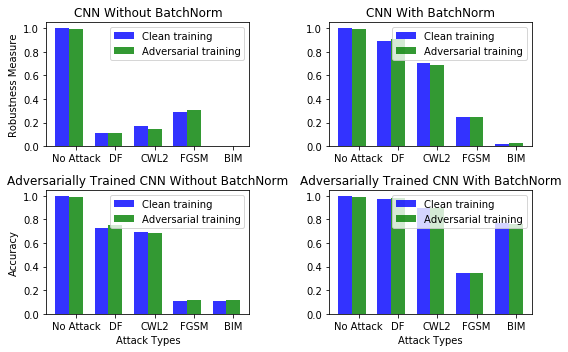

In [124]:
import matplotlib.pyplot as plt
# data to plot
n_groups = 5
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
plt.figure(figsize=(8,5))
# plt.suptitle("Loss Sensitivity for Cifar10 models with and without Adversarial training")

ax1 = plt.subplot(2, 2, 1)
rects1 = plt.bar(index, acc1, bar_width, alpha=opacity, color='b', label='Clean training')
rects2 = plt.bar(index + bar_width, test_acc1, bar_width, alpha=opacity, color='g', label='Adversarial training')
plt.ylabel('Robustness Measure')
ax1.set_title('CNN Without BatchNorm')
plt.xticks(index + bar_width, ('No Attack', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

ax2 = plt.subplot(2, 2, 2)
rects5 = plt.bar(index, acc_bn1, bar_width, alpha=opacity, color='b', label='Clean training')
rects6 = plt.bar(index + bar_width, test_acc_bn1, bar_width, alpha=opacity, color='g', label='Adversarial training')
ax2.set_title('CNN With BatchNorm')
plt.xticks(index + bar_width, ('No Attack', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()


ax3 = plt.subplot(2, 2, 3)
rects3 = plt.bar(index, acc1_adv, bar_width, alpha=opacity, color='b', label='Clean training')
rects4 = plt.bar(index + bar_width, test_acc1_adv, bar_width, alpha=opacity, color='g', label='Adversarial training')
plt.xlabel('Attack Types')
plt.ylabel('Accuracy')
ax3.set_title('Adversarially Trained CNN Without BatchNorm')
plt.xticks(index + bar_width, ('No Attack', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

ax4 = plt.subplot(2, 2, 4)
rects7 = plt.bar(index, acc_bn1_adv, bar_width, alpha=opacity, color='b', label='Clean training')
rects8 = plt.bar(index + bar_width, test_acc_bn1_adv, bar_width, alpha=opacity, color='g', label='Adversarial training')
plt.xlabel('Attack Types')
ax4.set_title('Adversarially Trained CNN With BatchNorm')
plt.xticks(index + bar_width, ('No Attack', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

# plt.constrained_layout()
plt.tight_layout()

# Loss Sensitivity

In [113]:
import numpy.linalg as la
def loss_sensitivity(classifier, x, y):
    grads = classifier.loss_gradient(x, y)
    norm = la.norm(grads.reshape(grads.shape[0], -1), ord=2, axis=1)
    return np.mean(norm)

In [119]:
ls_clean_bn = loss_sensitivity(loaded_vanilla_clf_with_bn[0], x_train[:3000], y_train[:3000])
ls_df_bn = loss_sensitivity(loaded_vanilla_clf_with_bn[0], x_train_deepfool_adv[:3000], y_train[:3000])
ls_cl2_bn = loss_sensitivity(loaded_vanilla_clf_with_bn[0], x_train_cl2_adv[:3000], y_train[:3000])
ls_fgsm_bn = loss_sensitivity(loaded_vanilla_clf_with_bn[0], x_train_fgsm_adv[:3000], y_train[:3000])
ls_ifgsm_bn = loss_sensitivity(loaded_vanilla_clf_with_bn[0], x_train_ifgsm_adv1[:3000], y_train[:3000])

ls_clean = loss_sensitivity(loaded_vanilla_clf[0], x_train[:3000], y_train[:3000])
ls_df = loss_sensitivity(loaded_vanilla_clf[0], x_train_deepfool_adv[:3000], y_train[:3000])
ls_cl2 = loss_sensitivity(loaded_vanilla_clf[0], x_train_cl2_adv[:3000], y_train[:3000])
ls_fgsm = loss_sensitivity(loaded_vanilla_clf[0], x_train_fgsm_adv[:3000], y_train[:3000])
ls_ifgsm = loss_sensitivity(loaded_vanilla_clf[0], x_train_ifgsm_adv1[:3000], y_train[:3000])

In [117]:
adv_ls_clean_bn = loss_sensitivity(loaded_vanilla_clf_with_bn_adv[0], x_train[:3000], y_train[:3000])
adv_ls_df_bn = loss_sensitivity(loaded_vanilla_clf_with_bn_adv[0], x_train_deepfool_adv[:3000], y_train[:3000])
adv_ls_cl2_bn = loss_sensitivity(loaded_vanilla_clf_with_bn_adv[0], x_train_cl2_adv[:3000], y_train[:3000])
adv_ls_fgsm_bn = loss_sensitivity(loaded_vanilla_clf_with_bn_adv[0], x_train_fgsm_adv[:3000], y_train[:3000])
adv_ls_ifgsm_bn = loss_sensitivity(loaded_vanilla_clf_with_bn_adv[0], x_train_ifgsm_adv1[:3000], y_train[:3000])

adv_ls_clean = loss_sensitivity(loaded_vanilla_clf_adv[0], x_train[:3000], y_train[:3000])
adv_ls_df = loss_sensitivity(loaded_vanilla_clf_adv[0], x_train_deepfool_adv[:3000], y_train[:3000])
adv_ls_cl2 = loss_sensitivity(loaded_vanilla_clf_adv[0], x_train_cl2_adv[:3000], y_train[:3000])
adv_ls_fgsm = loss_sensitivity(loaded_vanilla_clf_adv[0], x_train_fgsm_adv[:3000], y_train[:3000])
adv_ls_ifgsm = loss_sensitivity(loaded_vanilla_clf_adv[0], x_train_ifgsm_adv1[:3000], y_train[:3000])

In [120]:
print(
ls_clean_bn, ls_df_bn, ls_cl2_bn, ls_fgsm_bn, ls_ifgsm_bn, 
ls_clean, ls_df, ls_cl2, ls_fgsm, ls_ifgsm,    
adv_ls_clean_bn, adv_ls_df_bn,adv_ls_cl2_bn, adv_ls_fgsm_bn, adv_ls_ifgsm_bn, 
adv_ls_clean, adv_ls_df, adv_ls_cl2, adv_ls_fgsm, adv_ls_ifgsm)

0.012740754 5.3288774 11.095702 43.53506 58.871468 0.0025929157 8.39362 13.644957 25.071657 42.407196 0.012593708 2.0581658 4.79725 116.93578 39.367527 0.0007275245 30.314804 18.210506 717.444 827.35565


In [122]:
adv_ls_bn = (adv_ls_clean_bn, adv_ls_df_bn, adv_ls_cl2_bn, adv_ls_fgsm_bn, adv_ls_ifgsm_bn)
adv_ls = (adv_ls_clean, adv_ls_df, adv_ls_cl2, adv_ls_fgsm, adv_ls_ifgsm)

ls_bn = (ls_clean_bn, ls_df_bn, ls_cl2_bn, ls_fgsm_bn, ls_ifgsm_bn)
ls = (ls_clean, ls_df, ls_cl2, ls_fgsm, ls_ifgsm)
print(adv_ls_bn, adv_ls, ls_bn, ls)

(0.012593708, 2.0581658, 4.79725, 116.93578, 39.367527) (0.0007275245, 30.314804, 18.210506, 717.444, 827.35565) (0.012740754, 5.3288774, 11.095702, 43.53506, 58.871468) (0.0025929157, 8.39362, 13.644957, 25.071657, 42.407196)


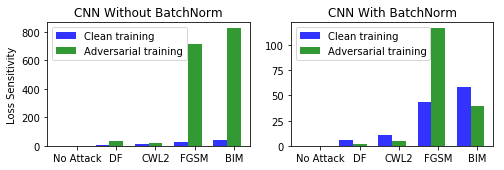

In [123]:
# data to plot
n_groups = 5
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
plt.figure(figsize=(8,5))
# plt.suptitle("Loss Sensitivity for Cifar10 models with and without Adversarial training")

ax1 = plt.subplot(2, 2, 1)
rects1 = plt.bar(index, ls, bar_width, alpha=opacity, color='b', label='Clean training')
rects2 = plt.bar(index + bar_width, adv_ls, bar_width, alpha=opacity, color='g', label='Adversarial training')
plt.ylabel('Loss Sensitivity')
ax1.set_title('CNN Without BatchNorm')
plt.xticks(index + bar_width, ('No Attack', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

ax2 = plt.subplot(2, 2, 2)
rects5 = plt.bar(index, ls_bn, bar_width, alpha=opacity, color='b', label='Clean training')
rects6 = plt.bar(index + bar_width, adv_ls_bn, bar_width, alpha=opacity, color='g', label='Adversarial training')
ax2.set_title('CNN With BatchNorm')
plt.xticks(index + bar_width, ('No Attack', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()